# Бриф «Лаборатории исследований гражданского общества». Определение уязвимых групп населения 

Задача:
* кластеризовать регионы России и определить, какие из них наиболее
остро нуждаются в помощи малообеспеченным/неблагополучным
слоям населения;
* описать группы населения, сталкивающиеся с бедностью;
* определить:
    - влияет ли число детей, пенсионеров и других социально уязвимых
групп на уровень бедности в регионе;
    - связаны ли уровень бедности/социального неблагополучия с
производством и потреблением в регионе;
    - какие ещё зависимости можно наблюдать относительно
социально незащищённых слоёв населения.

Данные:
* child_mortality_rural_1990_2021.xls — число умерших на первом году
жизни детей за год, по всем регионам, в сельской местности.
* child_mortality_urban_1990_2021.xls — число умерших на первом году
жизни детей за год, по всем регионам, в городской местности.
* disabled_total_by_age_2017_2022.csv — число людей с инвалидностью
по регионам, по месяцам, по возрастным группам.
* morbidity_2005_2020_age_disease.xls — заболеваемость на 100 тыс.
человек населения, по возрастным группам и группам заболеваний.
* poverty_percent_by_regions_1992_2020.csv — процент людей, живущих
за чертой бедности (с денежными доходами ниже величины
прожиточного минимума), оценка за год по регионам.
* welfare_expense_share_2015_2020 — расходы на социальную политику от
общих расходов бюджета региона, % в год*.
* cash_real_income_wages_2015_2020 — среднедушевые и реальные
денежные доходы населения, номинальная и реальная начисленная
зарплата, по регионам*.
* poverty_socdem_20*.xls — распределение малоимущего населения по
социально-демографическим группам (дети, трудящиеся,
пенсионеры) за 2017–2020 гг., по регионам.
* housing_2020 — характеристика жилищных условий домохозяйств.
Оценка домохозяйствами состояния занимаемого ими жилого
помещения, обследование 2020 года*.
* population.xlsx — численность населения по регионам и
федеральным округам на 1 января каждого года за 1999–2022 гг.
* gross_regional_product_1996_2020.xls — валовой региональный продукт
на душу населения, в рублях.
* regional_production_*_*.csv — объём отгруженных товаров
собственного производства или работ/услуг, выполненных
собственными силами, по видам деятельности за 2005–2016 гг.,
2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг).
* retail_turnover_per_capita_2000_2021.xls — оборот розничной
торговли на душу населения, в рублях.


In [235]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt


## Анализ и обработка данных

In [2]:
def drop_federal_district(df, feature):
    """Функция для предобработки регионов (удаляет строки с федеральными округами, оставляет только оласти края и республики)

    Args:
        df (pd.DataFrame): датафрейм
        feature (str): название признака по которому нужно фильтровать данные

    Returns:
        pd.DataFrame: новый отфильтрованный датасет 
    """
    
    pat = "край$|область$|республика" #шаблон для поиска подстроки в строке
    t = df.copy()
    t[feature] = t[feature].apply(lambda x: x.strip())
    t = t[t[feature].str.contains(pat=pat, case=False)].reset_index(drop=True)
    # если в строке встречаются выражения в скобках или перенос строки, заменить на пробел
    pt = r"[\(].*[\)]|\n+"
    t[feature] = t[feature].apply(lambda x: x.replace(re.findall(pt, x)[0], ' ').strip().replace('  ', ' ') if re.findall(pt, x) else x)
    
    return t

In [94]:
#объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности 
regional_production = pd.read_csv(r'social_russia_data\regional_production_2017_2020.csv')
regional_production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            604 non-null    object 
 1   production_field  604 non-null    object 
 2   2017              604 non-null    float64
 3   2018              604 non-null    float64
 4   2019              604 non-null    float64
 5   2020              604 non-null    float64
dtypes: float64(4), object(2)
memory usage: 28.4+ KB


In [95]:
# В каждом файле данные и по регионам и по округам - это дублирование информации, поэтому для начала нужно нужно отсеять федеральные округа
regional_production = drop_federal_district(regional_production, 'region')
regional_production

,region,production_field,2017,2018,2019,2020
0,Белгородская область,ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ,116588313.5,1.488634e+08,1.783899e+08,1.898038e+08
1,Белгородская область,ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА,629092604.8,7.108288e+08,7.226997e+08,7.463807e+08
2,Белгородская область,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПА...",27030715.9,2.680549e+07,2.654258e+07,2.678738e+07
3,Белгородская область,"ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОР...",10614103.8,8.936415e+06,1.140417e+07,1.117503e+07
4,Белгородская область,Промышленное производство (промышленность),783325738.0,8.954341e+08,9.390364e+08,9.741469e+08
...,...,...,...,...,...,...
378,Еврейская автономная область,ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ,7593200.7,1.033014e+07,1.397169e+07,1.709371e+07
379,Еврейская автономная область,ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА,6743433.7,6.631528e+06,6.622621e+06,5.460453e+06
380,Еврейская автономная область,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПА...",4209453.5,4.454820e+06,4.757778e+06,4.967490e+06
381,Еврейская автономная область,"ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОР...",445536.3,5.188002e+05,4.425363e+05,4.477501e+05


В задаче указано разделить регионы по группам, поэтому нужно взять от каждого файла самые свежие данные. Среди всех таблиц есть одна (характеристика жилищных условий домохозяйств) только за 2020 год, значит за основу нужно брать этот год.

In [96]:
#т.к. было определено с годом, то остальные нужно удалить
regional_production.drop('2017	2018	2019'.split(), axis=1, inplace=True)
# далее признак production_field нужно перевести в столбцы, пропуски заполнить нулями
regional_production = pd.pivot_table(data=regional_production, columns=['production_field'], values='2020', index='region').reset_index()
regional_production = regional_production.fillna(0)
# для простоты переименую столбцы
regional_production = regional_production.rename(columns={'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ': 'водоснабжение', 'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА':'электроэнергия'})
regional_production.columns = [col.lower() for col in regional_production.columns]
regional_production

,region,водоснабжение,добыча полезных ископаемых,электроэнергия,обрабатывающие производства,промышленное производство (промышленность)
0,Алтайский край,10454410.50,9146146.1,4.474102e+07,3.618801e+08,4.262217e+08
1,Амурская область,3471369.50,116722688.8,4.300032e+07,3.909386e+07,2.022882e+08
2,Архангельская область,6543248.07,286207903.7,4.140092e+07,2.608571e+08,5.950092e+08
3,Астраханская область,6497362.30,249844173.9,2.992926e+07,7.602808e+07,3.622989e+08
4,Белгородская область,11175025.30,189803813.7,2.678738e+07,7.463807e+08,9.741469e+08
...,...,...,...,...,...,...
72,Хабаровский край,9521832.90,27568168.6,5.792380e+07,4.068266e+08,5.018404e+08
73,Челябинская область,37238860.60,139619313.5,1.294978e+08,1.412224e+09,1.718580e+09
74,Чеченская Республика,2323171.00,4552198.6,2.468593e+07,1.193136e+07,4.349266e+07
75,Чувашская Республика - Чувашия,6463987.70,470434.3,2.428670e+07,2.218087e+08,2.530298e+08


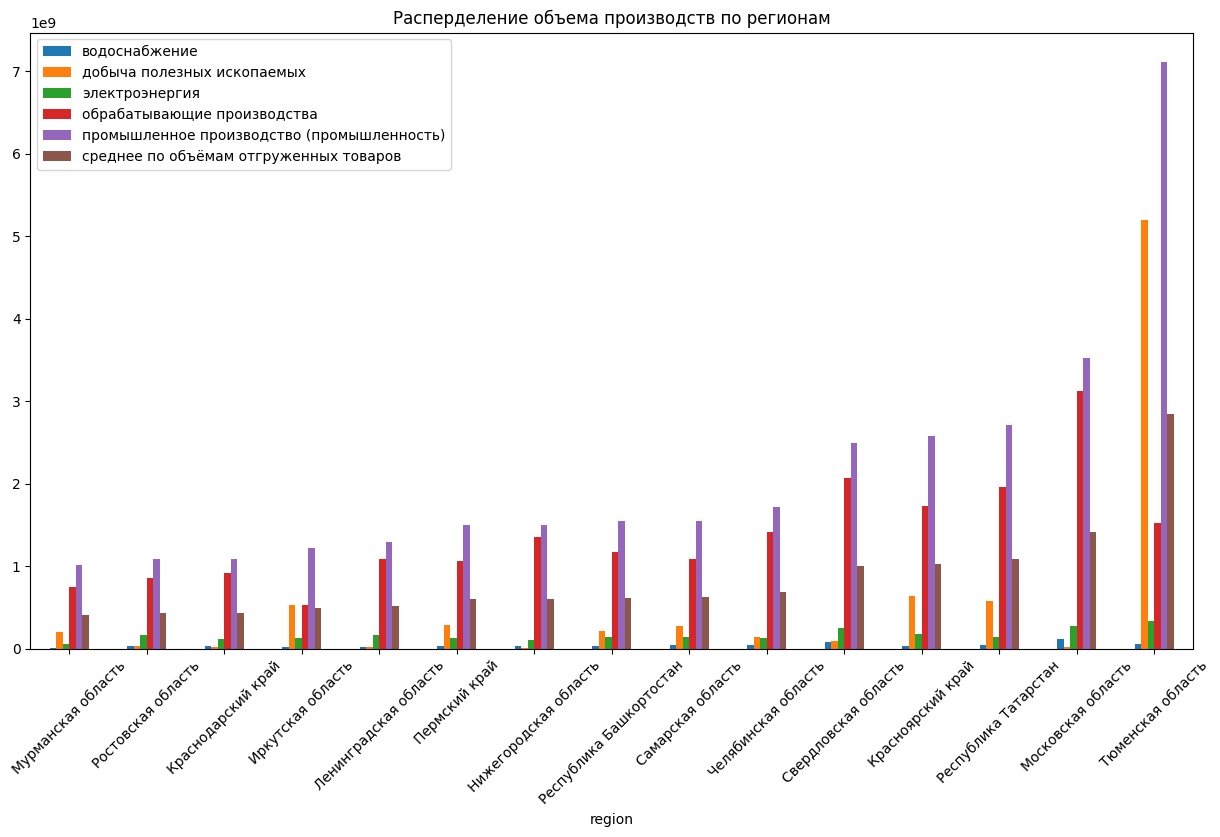

In [97]:
# для наглядности посчитаю среднее значение по всем производствам и отображу топ 15 регионов на графике
regional_production['среднее по объёмам отгруженных товаров'] = regional_production.iloc[:, 1:].mean(axis=1)
regional_production.set_index('region').sort_values(by='среднее по объёмам отгруженных товаров').tail(15).plot(
    rot=45, 
    figsize=(15, 8), 
    kind='bar',
    title='Расперделение объема производств по регионам'
);

Лидер по объему производства - Тюменская область, однако, в сфере обрабатывающих производств - Московская область на первом месте.

In [98]:
#процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам.
poverty_data = pd.read_csv(r'social_russia_data\poverty_percent_by_regions_1992_2020.csv')
poverty_data

,region,year,poverty_percent
0,Российская Федерация,1992,33.5
1,Российская Федерация,1993,31.3
2,Российская Федерация,1994,22.4
3,Российская Федерация,1995,24.8
4,Российская Федерация,1996,22.1
...,...,...,...
2334,Чукотский автономный округ,2017,8.5
2335,Чукотский автономный округ,2018,8.8
2336,Чукотский автономный округ,2019,8.5
2337,Чукотский автономный округ,2020,8.0


In [99]:
# такие же оперции по предобработке данных делаю и с остальными данными
poverty_data = drop_federal_district(poverty_data, 'region')
poverty_data = poverty_data[poverty_data['year'] == 2020].drop('year', axis=1).reset_index(drop=True)
poverty_data = poverty_data.rename(columns={'poverty_percent': 'процент людей, живущих за чертой бедности'})
poverty_data

,region,"процент людей, живущих за чертой бедности"
0,Белгородская область,7.2
1,Брянская область,13.6
2,Владимирская область,12.5
3,Воронежская область,8.5
4,Ивановская область,13.7
...,...,...
72,Хабаровский край,12.0
73,Амурская область,15.2
74,Магаданская область,8.7
75,Сахалинская область,7.7


In [100]:
#распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2020 гг., по регионам
socdem = pd.read_excel(r'social_russia_data\poverty_socdem_2020.xls', header=2).rename(columns={'Unnamed: 0':'region'})
socdem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   region                                     88 non-null     object 
 1   Все население                              88 non-null     int64  
 2   Дети в возрасте до 16 лет                  76 non-null     float64
 3   Население старше трудоспособного возраста  76 non-null     float64
 4   Население трудоспособного возраста         76 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.6+ KB


In [101]:
# пропусков в данных немного, признаки независимые поэтому заполню нулями
socdem = drop_federal_district(socdem, 'region')
socdem.fillna(0, inplace=True)
socdem.drop('Все население', axis=1, inplace=True)
socdem.rename(columns={'Дети в возрасте до 16 лет':'из числа малоимущего населения: дети', 
                       'Население трудоспособного возраста':'из числа малоимущего населения: трудящиеся', 
                       'Население старше трудоспособного возраста':'из числа малоимущего населения: пенсионеры'}, inplace=True)

In [102]:
#число умерших на первом году жизни детей за год, по всем регионам, в сельской местности.
child_mortality_rural = pd.read_excel(r'social_russia_data\child_mortality_rural_1990_2021.xls', header=2)

#число умерших на первом году жизни детей за год, по всем регионам, в городской местности
child_mortality_urban = pd.read_excel(r'social_russia_data\child_mortality_urban_1990_2021.xls', header=2)

child_mortality = pd.concat([child_mortality_rural, child_mortality_urban], axis=0, ignore_index=True)
child_mortality

,Unnamed: 0,Unnamed: 1,Unnamed: 2,1990,1991,1992,1993,1994,1995,1996,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Российская Федерация,Оба пола,сельское население,11186.0,10943.0,10111.0,9840.0,9010.0,8582.0,7983.0,...,5463.0,5059.0,4681.0,4165.0,3568.0,3032.0,2521.0,2122.0,1916.0,1852.0
1,Центральный федеральный округ,Оба пола,сельское население,1615.0,1550.0,1361.0,1426.0,1347.0,1321.0,1200.0,...,625.0,608.0,487.0,490.0,426.0,347.0,291.0,211.0,228.0,212.0
2,Белгородская область,Оба пола,сельское население,103.0,92.0,75.0,79.0,80.0,72.0,72.0,...,43.0,48.0,41.0,42.0,36.0,34.0,33.0,16.0,22.0,20.0
3,Брянская область,Оба пола,сельское население,124.0,109.0,83.0,121.0,99.0,104.0,96.0,...,46.0,47.0,39.0,44.0,36.0,31.0,12.0,11.0,12.0,13.0
4,Владимирская область,Оба пола,сельское население,80.0,58.0,60.0,62.0,46.0,50.0,47.0,...,30.0,31.0,23.0,31.0,28.0,17.0,22.0,15.0,10.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,Северо-Кавказский район,Оба пола,городское население,2591.0,2594.0,2433.0,2112.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,Уральский район,Оба пола,городское население,3402.0,3044.0,2707.0,2626.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,Западно-Сибирский район,Оба пола,городское население,2645.0,2404.0,2132.0,2095.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,Восточно-Сибирский район,Оба пола,городское население,1898.0,1794.0,1498.0,1518.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
child_mortality = child_mortality.rename(columns={'Unnamed: 0':'region', 'Unnamed: 2':'Структура населения'}).drop('Unnamed: 1',axis=1)
child_mortality = drop_federal_district(child_mortality, 'region')
child_mortality


,region,Структура населения,1990,1991,1992,1993,1994,1995,1996,1997,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Белгородская область,сельское население,103.0,92.0,75.0,79.0,80.0,72.0,72.0,67.0,...,43.0,48.0,41.0,42.0,36.0,34.0,33.0,16.0,22.0,20.0
1,Брянская область,сельское население,124.0,109.0,83.0,121.0,99.0,104.0,96.0,67.0,...,46.0,47.0,39.0,44.0,36.0,31.0,12.0,11.0,12.0,13.0
2,Владимирская область,сельское население,80.0,58.0,60.0,62.0,46.0,50.0,47.0,38.0,...,30.0,31.0,23.0,31.0,28.0,17.0,22.0,15.0,10.0,14.0
3,Воронежская область,сельское население,138.0,179.0,156.0,149.0,154.0,137.0,133.0,132.0,...,32.0,33.0,33.0,25.0,24.0,18.0,22.0,7.0,12.0,10.0
4,Ивановская область,сельское население,74.0,44.0,40.0,57.0,50.0,41.0,31.0,39.0,...,13.0,19.0,10.0,16.0,15.0,4.0,7.0,9.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Хабаровский край,городское население,354.0,278.0,224.0,218.0,230.0,196.0,148.0,157.0,...,162.0,184.0,146.0,97.0,88.0,88.0,65.0,52.0,53.0,49.0
150,Амурская область,городское население,201.0,169.0,174.0,136.0,131.0,151.0,145.0,150.0,...,98.0,69.0,62.0,52.0,30.0,28.0,29.0,27.0,29.0,21.0
151,Магаданская область,городское население,76.0,71.0,44.0,39.0,36.0,27.0,35.0,29.0,...,14.0,17.0,11.0,9.0,6.0,6.0,5.0,8.0,4.0,7.0
152,Сахалинская область,городское население,142.0,93.0,101.0,85.0,100.0,122.0,72.0,74.0,...,27.0,24.0,33.0,33.0,17.0,25.0,12.0,22.0,20.0,14.0


In [104]:
child_mortality = drop_federal_district(child_mortality, 'region')
#child_mortality = child_mortality.drop(list(filter(lambda x: x!='2020', [col for col in child_mortality.columns[2:]])), axis=1)
child_mortality = child_mortality[['region', 'Структура населения', '2020']] # оставляю только 2020 год

child_mortality = child_mortality.groupby('region', as_index=False)['2020'].agg('sum').rename(columns={'2020':'число умерших на первом году жизни'})
child_mortality

,region,число умерших на первом году жизни
0,Алтайский край,97.0
1,Амурская область,42.0
2,Архангельская область,33.0
3,Астраханская область,64.0
4,Белгородская область,47.0
...,...,...
72,Хабаровский край,58.0
73,Челябинская область,133.0
74,Чеченская Республика,181.0
75,Чувашская Республика - Чувашия,24.0


<Axes: ylabel='region'>

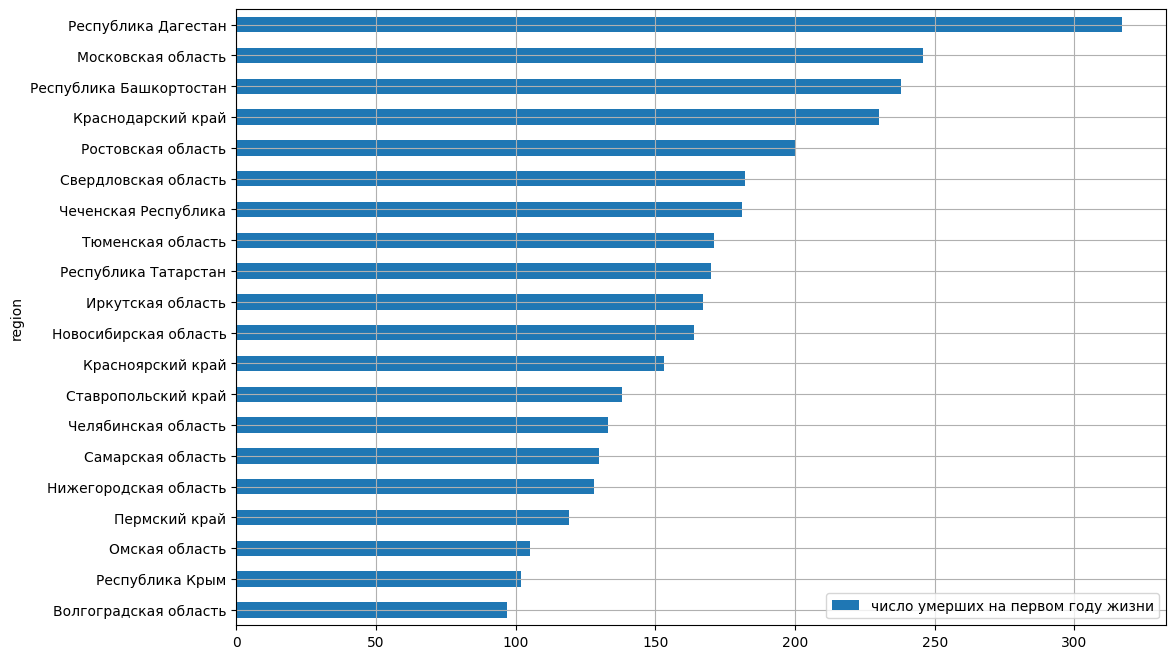

In [105]:
child_mortality.set_index('region').sort_values('число умерших на первом году жизни').tail(20).plot(kind='barh', figsize=(12,8), grid=True)

В Дагестане значительный перевес по числу умерших в первом году жизни, далее я проанализирую какой процент от общего числа населения по регионам.

In [202]:
#численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг.
population = pd.read_excel(r'social_russia_data\population.xlsx', header=1)
population

,Unnamed: 0,Unnamed: 1,январь 1999 г.,январь 2000 г.,январь 2001 г.,январь 2002 г.,январь 2003 г.,январь 2004 г.,январь 2005 г.,январь 2006 г.,...,январь 2013 г.,январь 2014 г.,январь 2015 г.,январь 2016 г.,январь 2017 г.,январь 2018 г.,январь 2019 г.,январь 2020 г.,январь 2021 г.,январь 2022 г.
0,все население,w2:p_mest:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Российская Федерация,643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Раздел 1. Муниципальные образования субъектов ...,00000000000,147539426.0,146890128.0,146303611.0,145649334.0,144963650.0,144333586.0,143801046.0,143236582.0,...,143347059.0,143666931.0,146267288.0,146544710.0,146804372.0,146880432.0,146780720.0,146748590.0,146171015.0,145557576.0
3,Центральный федеральный округ,030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Раздел 1. Муниципальные образования субъектов ...,00000000000,38311159.0,38227656.0,38175094.0,38068452.0,37946810.0,37965073.0,38044068.0,38109006.0,...,38678913.0,38819874.0,38951479.0,39104319.0,39209582.0,39311413.0,39378059.0,39433556.0,39250960.0,39104400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,Раздел 1. Муниципальные образования субъектов ...,00000000000,199172.0,195135.0,193198.0,191899.0,190585.0,188412.0,185763.0,181653.0,...,172671.0,170377.0,168368.0,166120.0,164217.0,162014.0,159913.0,158305.0,156500.0,153831.0
364,Чукотский автономный округ,77000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,Раздел 1. Муниципальные образования субъектов ...,00000000000,67010.0,61613.0,57534.0,55309.0,53137.0,51933.0,51815.0,52391.0,...,50780.0,50555.0,50540.0,50157.0,49822.0,49348.0,49663.0,50288.0,49527.0,50040.0
366,Крымский федеральный округ,039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
# здесь данные смещены по строкам, поэтому признак с регионами нужно сместить
population['Unnamed: 0'] = population['Unnamed: 0'].shift(periods=1) 
# проделываю такиие же операции с данными как и на предъидущих таблицах 
# (удаление округов и областей, переименования признака с регионами для дальнейшего объединения)
population = population.drop(index=[0,1])
population = population.drop(columns=['Unnamed: 1'])
population = population.rename(columns={'Unnamed: 0':'region'})
population = drop_federal_district(population, 'region')
population.columns = [re.findall(r"\d{4}", col)[0] if re.findall(r"\d{4}", col) else col for col in population.columns]
population = population.drop(list(filter(lambda x: x!='2020', [col for col in population.columns[1:]])), axis=1)
population = population.rename(columns={'2020':'численность населения'})
population

,region,численность населения
0,Белгородская область,1549151.0
1,Брянская область,1192491.0
2,Владимирская область,1358416.0
3,Воронежская область,2324205.0
4,Ивановская область,997135.0
...,...,...
72,Хабаровский край,1315643.0
73,Амурская область,790044.0
74,Магаданская область,140149.0
75,Сахалинская область,488257.0


<BarContainer object of 20 artists>


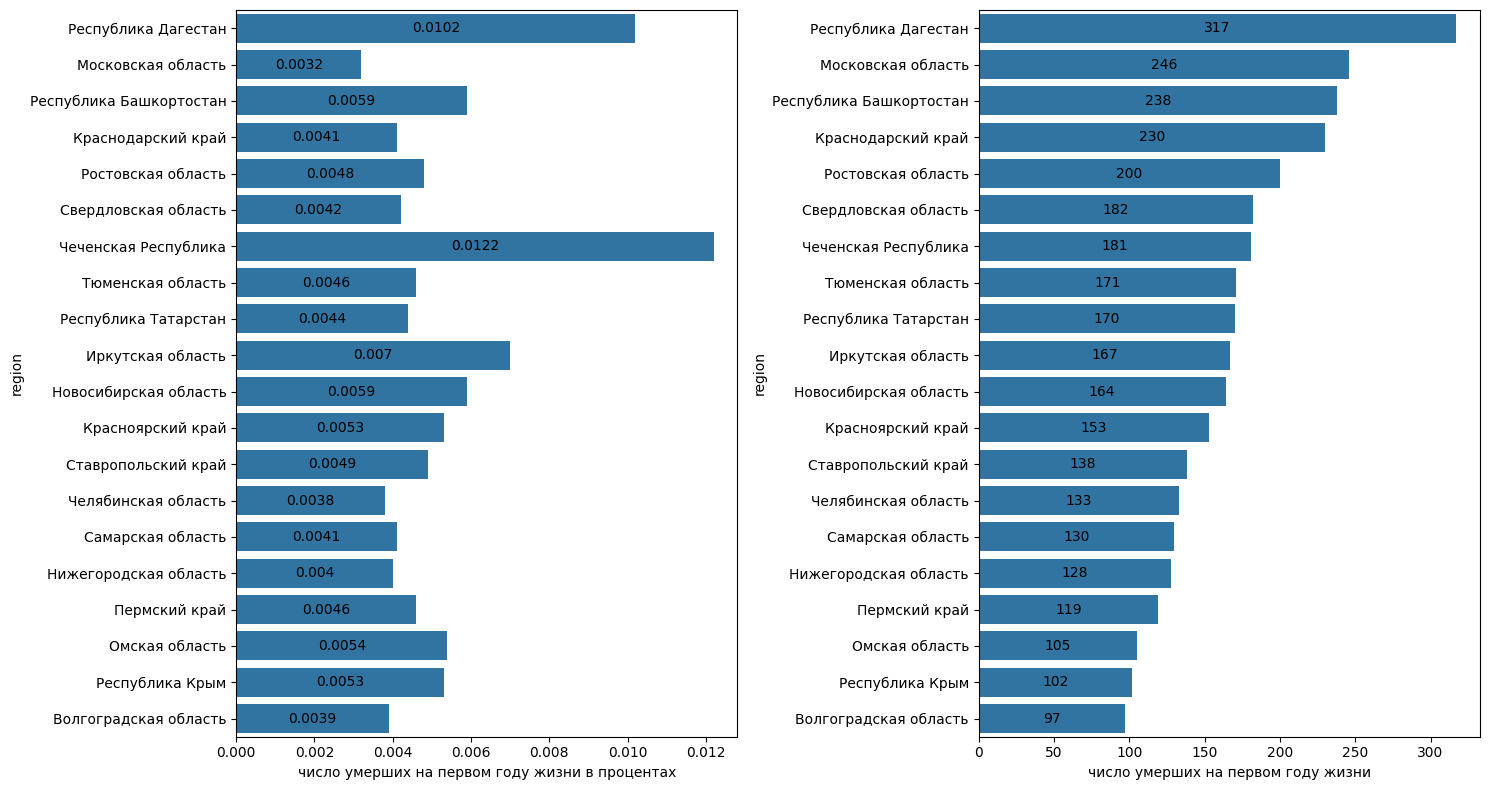

In [108]:
t = pd.merge(child_mortality, population, on='region')
feature1 = 'численность населения'
feature2 = 'число умерших на первом году жизни'
feature3 = 'число умерших на первом году жизни в процентах'
t[feature3] = (t[feature2] / t[feature1] * 100).round(4)

idx = t.sort_values(by=feature2, ascending=False).head(20).index
fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.barplot(data=t.iloc[idx, :], y='region', x=feature3, ax=ax[0])
for i in ax[0].containers:
    print(i)
    ax[0].bar_label(i, label_type='center')
sns.barplot(data=t.iloc[idx, :], y='region', x=feature2, ax=ax[1])
for i in ax[1].containers:
    ax[1].bar_label(i, label_type='center')
# sns.barplot(data=t.iloc[idx, :], y='region', x='population', ax=ax[2])
# for i in ax[2].containers:
#     ax[2].bar_label(i, )
plt.tight_layout()

Как видно на графике в процентном соотношении данные отличаются

In [109]:
# среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная зарплата, по регионам*.
incomes = pd.read_excel(r'social_russia_data\cash_real_income_wages_2015_2020.xlsx', sheet_name=None) 

In [110]:
incomes.pop('desc')
for dt in incomes:
    incomes[dt] = pd.melt(incomes[dt], id_vars='region', value_vars=incomes[dt].columns[1:], value_name=dt, var_name='year') # перевожу столбцы с годами в индекс
incomes = list(map(lambda x: incomes[x], incomes))
incomes = reduce(lambda left, right: pd.merge(left, right, on=['region', 'year']), incomes) # объединяю все таблицы по региону и году
incomes

,region,year,per_capita_cash_income,real_incomes,formal_wage_paid,real_pay
0,Российская Федерация,2015,302541.0,96.42,34030.0,91.01
1,Центральный\n федеральный округ,2015,38832.0,96.20,41961.0,90.3
2,Белгородская область,2015,28043.0,99.30,25456.0,93.2
3,Брянская область,2015,23428.0,97.00,21679.0,89
4,Владимирская область,2015,22712.0,99.50,23877.0,91
...,...,...,...,...,...,...
655,Амурская область,2020,35499.0,100.30,52430.0,105.2
656,Магаданская область,2020,70864.0,104.30,102843.0,105.0
657,Сахалинская область,2020,60770.0,98.60,92518.0,101.7
658,Еврейская автономная область,2020,28048.0,99.20,46237.0,103.7


In [111]:
incomes = drop_federal_district(incomes, 'region')
incomes = incomes[incomes['year'] == 2020].drop('year', axis=1).reset_index(drop=True)
incomes = incomes.rename(columns={'per_capita_cash_income': 'среднедушевые денежные доходы',
                                  'real_incomes':'реальные денежные доходы, в процентах',
                                  'formal_wage_paid':'среднемесячная номинальная зп',
                                  'real_pay':'реальная начисленная зп, в процентах'})
incomes

,region,среднедушевые денежные доходы,"реальные денежные доходы, в процентах",среднемесячная номинальная зп,"реальная начисленная зп, в процентах"
0,Белгородская область,32841.0,98.1,37442.0,104.8
1,Брянская область,28596.0,96.3,31946.0,102.9
2,Владимирская область,25922.0,98.0,35240.0,103.0
3,Воронежская область,32078.0,95.4,36317.0,103.2
4,Ивановская область,26277.0,97.2,29083.0,101.6
...,...,...,...,...,...
73,Хабаровский край,41740.0,96.2,53113.0,101.9
74,Амурская область,35499.0,100.3,52430.0,105.2
75,Магаданская область,70864.0,104.3,102843.0,105.0
76,Сахалинская область,60770.0,98.6,92518.0,101.7


In [112]:
#расходы на социальную политику от общих расходов бюджета региона, % в год*
social_expenses = pd.read_excel(r'social_russia_data\welfare_expense_share_2015_2020.xlsx')

In [113]:
social_expenses = social_expenses.drop(social_expenses.columns[1:-1], axis=1).rename(columns={2020:'расходы на социальную политику от общих расходов бюджета'})
social_expenses = drop_federal_district(social_expenses, 'region')
social_expenses

,region,расходы на социальную политику от общих расходов бюджета
0,Белгородская область,16.1
1,Брянская область,23.1
2,Владимирская область,26.0
3,Воронежская область,21.6
4,Ивановская область,25.1
...,...,...
73,Хабаровский край,25.7
74,Амурская область,21.7
75,Магаданская область,11.1
76,Сахалинская область,16.5


In [114]:
#валовой региональный продукт на душу населения, в рублях.
gross_regional_product = pd.read_excel(r'social_russia_data\gross_regional_product_1996_2020.xls', header=2)
gross_regional_product

,Unnamed: 0,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Российская Федерация,12225.0,13938.4,15371.1,26200.6,39532.3,49474.8,60611.4,74840.5,97691.9,...,317515.3,348641.5,377006.0,405147.7,449097.9,505337.7,543065.9,614333.2,646144.1,640519.0
1,Центральный федеральный округ,NaN,NaN,16564.4,31118.7,48205.0,58851.5,75739.2,94244.6,121487.7,...,417288.1,451517.2,494482.7,536607.9,580706.6,663881.8,711031.6,792780.9,835858.8,854978.5
2,Белгородская область,9575.6,10792.2,12242.8,21398.0,27969.5,33126.7,41327.4,50271.4,75629.4,...,331010.0,354570.6,368874.8,400820.8,447619.7,501467.8,539720.5,588641.5,617426.5,646569.0
3,Брянская область,7275.3,7175.7,7659.1,11752.4,17413.5,21511.9,27020.0,31953.4,37719.1,...,137187.1,164726.6,175865.0,196096.7,221080.0,258752.7,280630.1,304547.1,332442.8,347204.5
4,Владимирская область,7620.7,8431.3,9350.2,15457.1,21073.3,27170.0,32923.6,40809.4,49353.4,...,181842.6,200456.4,216320.8,232757.6,262945.5,309713.7,325043.1,349856.4,394560.3,410443.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Магаданская область,26438.6,30770.0,32315.5,50936.4,65704.6,89987.5,121272.5,135180.6,139840.3,...,464112.9,511125.4,587477.4,649745.4,854561.5,1054274.8,1117517.3,1236274.4,1518066.7,2035007.0
97,Сахалинская область,15476.9,19625.3,21428.2,45662.9,61595.8,84769.1,85927.4,116731.0,172004.4,...,1210003.9,1298440.0,1364874.7,1631919.0,1716734.4,1564707.9,1605079.4,2517125.0,2400858.1,2059206.5
98,Еврейская автономная область,7177.0,8355.6,7535.3,15344.9,19484.8,24877.5,35766.0,45196.1,60029.9,...,225065.5,246301.3,224042.7,247666.9,266405.8,294021.2,338826.6,339068.1,355545.7,400340.5
99,Чукотский автономный округ,30606.1,33540.9,37859.4,49746.0,65963.0,123130.9,187368.1,256992.1,238227.2,...,883368.7,896822.1,877612.8,1142504.1,1226152.0,1443771.7,1469675.0,1685134.1,1898634.8,2404271.2


In [115]:
gross_regional_product = pd.melt(gross_regional_product, id_vars='Unnamed: 0', value_vars=gross_regional_product.columns[1:], value_name='валовой региональный продукт', var_name='year')
gross_regional_product.rename(columns={'Unnamed: 0':'region'}, inplace=True)
gross_regional_product = gross_regional_product[gross_regional_product['year'] == '2020'].drop('year', axis=1).reset_index(drop=True)
gross_regional_product = drop_federal_district(gross_regional_product, 'region')
gross_regional_product

,region,валовой региональный продукт
0,Белгородская область,646569.0
1,Брянская область,347204.5
2,Владимирская область,410443.6
3,Воронежская область,459629.5
4,Ивановская область,273821.5
...,...,...
72,Хабаровский край,658239.5
73,Амурская область,571362.1
74,Магаданская область,2035007.0
75,Сахалинская область,2059206.5


In [116]:
# оборот розничной торговли на душу населения, в рублях
retial_data = pd.read_excel(r'social_russia_data\retail_turnover_per_capita_2000_2021.xls', header=2)
retial_data = retial_data.drop(index=0)

In [117]:
retial_data = retial_data.drop(filter(lambda x: x!='2020', [col for col in retial_data.columns[1:]]), axis=1)
retial_data.rename(columns={'Unnamed: 0':'region', '2020':'оборот розничной торговли на душу населения'}, inplace=True)
retial_data = drop_federal_district(retial_data, 'region')
retial_data

,region,оборот розничной торговли на душу населения
0,Белгородская область,237076
1,Брянская область,225643
2,Владимирская область,177680
3,Воронежская область,252416
4,Ивановская область,180314
...,...,...
72,Хабаровский край,277942
73,Амурская область,245233
74,Магаданская область,245817
75,Сахалинская область,338787


In [282]:
#характеристика жилищных условий домохозяйств. Оценка домохозяйствами состояния занимаемого ими жилого помещения, обследование 2020 года*.
housing = pd.read_excel(r'social_russia_data\housing_2020.xlsx', sheet_name=None)
housing.pop('desc')

#Сейчас в переменной находится словарь ключами которого являются названия листа из exel файл. Для объединеня таблиц через функцию reduce нужно преобразовать слварь в список.
housing = list(map(lambda x: housing[x].drop('затруднились ответить', axis=1), housing)) # преобразование словаря в список, индексы которого сами датафреймы
housing = reduce(lambda left, right: pd.merge(left, right, on='Регион'), housing)

for col in housing.columns[1:]:
    housing[col] = housing[col].apply(lambda x: 0 if type(x) == str else x).astype(float) # преобразование всех столбцов к типу float
housing.rename(columns={'Регион':'region'}, inplace=True)

housing['из всех домохозяйств, указавшие на стесненность проживания'] = housing.iloc[:, 10:13].sum(axis=1)

housing.drop(
    [
        'Число домохозяйств, проживающих во всех типах жилых помещений', 
        'Все домохозяйства', 
        'Размер жилой площади в расчете на члена домохозяйства'
    ] + [col for col in housing.columns if 'в том числе домохозяйства' in col or 'из них указавшие:' in col],
    axis=1,
    inplace=True
)

housing = drop_federal_district(housing, feature='region')

housing.columns

Index(['region', 'Размер общей площади в расчете на члена домохозяйства',
       'Число жилых комнат в расчете на одно домохозяйство',
       'из них домохозяйства, собирающиеся улучшить свои жилищные условия',
       'из числа домохозяйств, собирающихся улучшить свои жилищные условия: планируют вселиться в жилое помещение, строительство которого ведут (участвуют в долевом строительстве)',
       'из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются подать документы для постановки на очередь (и/или ожидают прохождения очереди)',
       'из числа домохозяйств, собирающихся улучшить свои жилищные условия: рассчитывают на получение нового жилья в связи со сносом дома',
       'из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются купить (построить) другое жилье',
       'из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются снимать жилье',
       'из числа домохозяйств, собирающихся улучшить свои жилищные условия:

In [119]:
#число людей с инвалидностью по регионам, по месяцам, по возрастным группам
disability_data = pd.read_csv(r'social_russia_data\disabled_total_by_age_2017_2022.csv', sep=',')
disability_data = drop_federal_district(disability_data, 'region')


disability_data = disability_data[disability_data['date'] == '2020-12-01'].reset_index(drop=True)
disability_data = disability_data.drop('date', axis=1)
disability_data

,region,total,18_30,31_40,41_50,51_60,60_
0,Белгородская область,192554.0,4983.0,9502.0,14994.0,29116.0,133959.0
1,Брянская область,104116.0,3441.0,6247.0,9757.0,17879.0,66792.0
2,Владимирская область,119211.0,3720.0,6662.0,9564.0,17698.0,81567.0
3,Воронежская область,212538.0,6637.0,12014.0,18040.0,37315.0,138532.0
4,Ивановская область,75423.0,2587.0,4570.0,6480.0,11207.0,50579.0
...,...,...,...,...,...,...,...
73,Магаданская область,5020.0,321.0,586.0,704.0,942.0,2467.0
74,Сахалинская область,21345.0,1386.0,2142.0,2850.0,3303.0,11664.0
75,Еврейская автономная область,12247.0,661.0,1181.0,1397.0,1725.0,7283.0
76,Республика Саха,52621.0,4130.0,5566.0,6954.0,10927.0,25044.0


In [67]:
#заболеваемость на 100 тыс. человек населения, по возрастным группам и группам заболеваний.
morbidity_data = pd.read_excel(r'social_russia_data\morbidity_2005_2020_age_disease.xls', header=2)
morbidity_data.rename(columns={'Unnamed: 0':'region', 'Unnamed: 1':'morbidity', 'Unnamed: 2':'age'}, inplace=True)
#данных за 2020 год нет

In [120]:
#рождённые в этом месяце, по регионам, без учёта мертворождённых
newborn = pd.read_csv(r'social_russia_data\newborn_2006_2022_monthly.csv', sep=';')
newborn.rename(columns={'Region':'region'})
newborn = newborn.drop('Unnamed: 198', axis=1)
month = "январь февраль март апрель май июнь июль август сентябрь октябрь ноябрь декабрь".split()
newborn.columns = ['region'] + [re.findall(r'\b\d{4}\b', col)[0]+'-'+str(month.index(col.split()[0])+1).rjust(2, '0')+'-01' for col in newborn.columns[1:]]

In [121]:
newborn = pd.melt(newborn, id_vars='region', value_vars=newborn.columns[1:], value_name='newborn', var_name='date')
newborn['date'] = pd.to_datetime(newborn['date'])
newborn['year'] = newborn['date'].dt.year
newborn.fillna('0', inplace=True)
newborn['newborn'] = newborn['newborn'].apply(lambda x: x.replace(',', '.') if type(x) == str else x).astype(float).map(round)
newborn = newborn.groupby(['region', 'year'], as_index=False)['newborn'].sum()
newborn = newborn[newborn['year'] == 2020].reset_index(drop=True)
newborn = newborn.drop('year', axis=1)
newborn = drop_federal_district(newborn, 'region')
newborn

,region,newborn
0,Алтайский край,19976
1,Амурская область,7853
2,Архангельская область,9500
3,Астраханская область,10911
4,Белгородская область,12352
...,...,...
72,Хабаровский край,13739
73,Челябинская область,33252
74,Чеченская Республика,30111
75,Чувашская Республика - Чувашия,11307


In [438]:
df = [
    regional_production.drop('среднее по объёмам отгруженных товаров', axis=1), poverty_data, socdem,
    child_mortality, population, incomes, social_expenses,
    gross_regional_product, retial_data, housing, disability_data,
    newborn
]

data = reduce(lambda left, right: pd.merge(left, right, on='region'), df)


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 37 columns):
 #   Column                                                                                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                                                                                       --------------  -----  
 0   region                                                                                                                                                                       69 non-null     object 
 1   водоснабжение                                                                                                                                                                69 non-null     float64
 2   добыча полезных ископаемых                                                          

In [439]:
data['кол-во людей, живущих за чертой бедности'] = (data['численность населения']\
    * (data['процент людей, живущих за чертой бедности'] / 100)).round() # 

data['реальная начисленная зп'] = data['среднемесячная номинальная зп']\
    * (data['реальная начисленная зп, в процентах'] / 100)

data['реальные денежные доходы'] = data['среднедушевые денежные доходы'] * (data['реальные денежные доходы, в процентах'] / 100)
data['малоимущее население: дети'] = (((data['процент людей, живущих за чертой бедности'] * data['из числа малоимущего населения: дети'] / 100) / 100) * data['численность населения']).round()
data['малоимущее население: пенсионеры'] = (((data['процент людей, живущих за чертой бедности'] * data['из числа малоимущего населения: пенсионеры'] / 100) / 100) * data['численность населения']).round()
data['малоимущее население: трудящиеся'] = (((data['процент людей, живущих за чертой бедности'] * data['из числа малоимущего населения: трудящиеся'] / 100) / 100) * data['численность населения']).round()
data = data.drop(
    [
        'домохозяйства, не собирающиеся улучшать свои жилищные условия', 
        'total', 'процент людей, живущих за чертой бедности',
        'реальная начисленная зп, в процентах', 'реальные денежные доходы, в процентах', 'среднемесячная номинальная зп',
        'среднедушевые денежные доходы', 'из числа малоимущего населения: пенсионеры', 'из числа малоимущего населения: трудящиеся', 'из числа малоимущего населения: дети'
    ],
    axis=1
)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 33 columns):
 #   Column                                                                                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                                                                                       --------------  -----  
 0   region                                                                                                                                                                       69 non-null     object 
 1   водоснабжение                                                                                                                                                                69 non-null     float64
 2   добыча полезных ископаемых                                                          

In [440]:
data.to_csv("population_data.csv", index=False) # сохраняю подготовленый набор данных

## Подготовка модели

In [204]:
# import pandas as pd
# data = pd.read_csv("population_data.csv")

In [205]:
from sklearn import preprocessing, metrics, cluster, mixture, decomposition
from sklearn.model_selection import train_test_split

# разбиваю данные 
X = data.drop(['region'], axis=1)
y = data[['region']]

In [206]:
# подготовлю 4 модели для кластеризации на разных типах данных
scaler = preprocessing.StandardScaler()
X_std = scaler.fit_transform(X)

minmax = preprocessing.MinMaxScaler()
X_minmax = minmax.fit_transform(X)

pca = decomposition.PCA(n_components=0.9)
X_pca = pca.fit_transform(X_std)

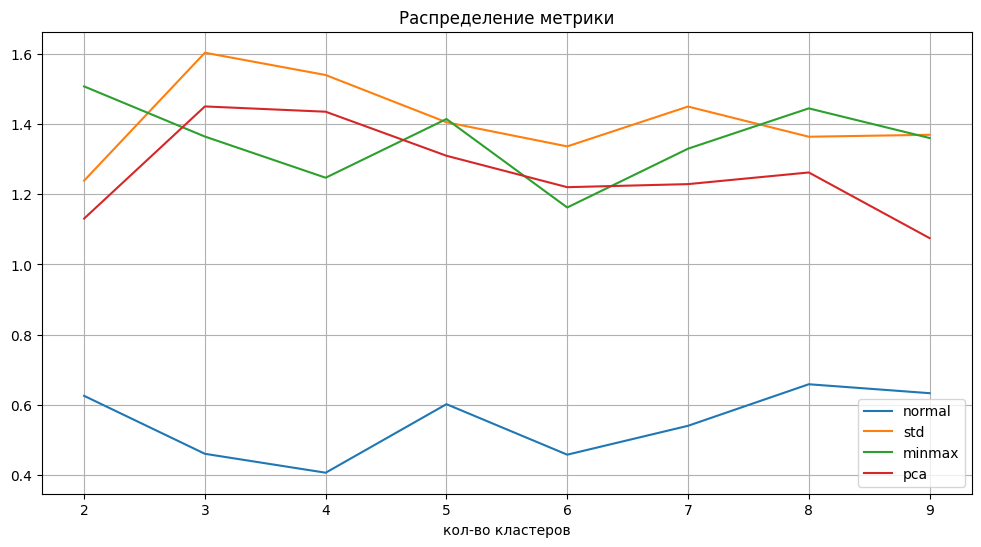

In [207]:
# т.к дданных в выборках немного буду использовать KMeans, в качестве метрики буду использовать Индекс Дэвиса — Болдина.
res = []
plt.figure(figsize=(12,6))
RANDOM_STATE = 2
for i in range(2, 10):
    model_1 = cluster.KMeans(n_clusters=i, random_state=RANDOM_STATE, n_init='auto')
    val_1 = metrics.davies_bouldin_score(X, model_1.fit_predict(X))
    model_2 = cluster.KMeans(n_clusters=i, random_state=RANDOM_STATE, n_init='auto')
    val_2 = metrics.davies_bouldin_score(X_std, model_2.fit_predict(X_std))
    model_3 = cluster.KMeans(n_clusters=i, random_state=RANDOM_STATE, n_init='auto')
    val_3 = metrics.davies_bouldin_score(X_minmax, model_3.fit_predict(X_minmax))
    model_4 = cluster.KMeans(n_clusters=i, random_state=RANDOM_STATE, n_init='auto')
    val_4 = metrics.davies_bouldin_score(X_pca, model_4.fit_predict(X_pca))
    
    res.append((i, val_1, val_2, val_3, val_4))
    
df = pd.DataFrame(res, columns=['n_cluster', 'X_normal', 'X_std', 'X_minmax', 'X_pca'])
plt.plot(df.n_cluster, df.X_normal, label='normal')
plt.plot(df.n_cluster, df.X_std, label='std')
plt.plot(df.n_cluster, df.X_minmax, label='minmax')
plt.plot(df.n_cluster, df.X_pca, label='pca')
plt.legend()
plt.title('Распределение метрики')
plt.xlabel('кол-во кластеров')
plt.grid()

Как видно на графике выше, лучше всего справилась модель обученная на "сырых" данных, разделила данные на 4 группы.

In [208]:
# фиксирую результат для дальнейшего исследования
model_normal = cluster.KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init='auto')
y['cluster'] = model_normal.fit_predict(X)

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_17152\4051080392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['cluster'] = model_normal.fit_predict(X)


In [196]:

def plot_avg_group(X, y, features: list|tuple, figsize=(10,18)):
    if not isinstance(features, (list, tuple)):
        raise AttributeError ('должен быть список или кортеж')
    cluster_sets = {}
    fig, axes = plt.subplots(len(features), 1, figsize=figsize)
    for i, col in enumerate(features):
        cluster_sets = {}
        for j, row in y.iterrows():
            name_key = f"кластер: {row.values[1]}"
            cluster_sets[name_key] = cluster_sets.get(name_key, [0, 0])[0] + data.loc[j, col], cluster_sets.get(name_key, [0, 0])[1] + 1
        
        cluster_sets_avg = {key: value[0] / value[1] for key, value in cluster_sets.items()}

        axes[i].bar(cluster_sets_avg.keys(), cluster_sets_avg.values())
        axes[i].set_title(f"среднее по признаку: {col}")
    fig.tight_layout()
    


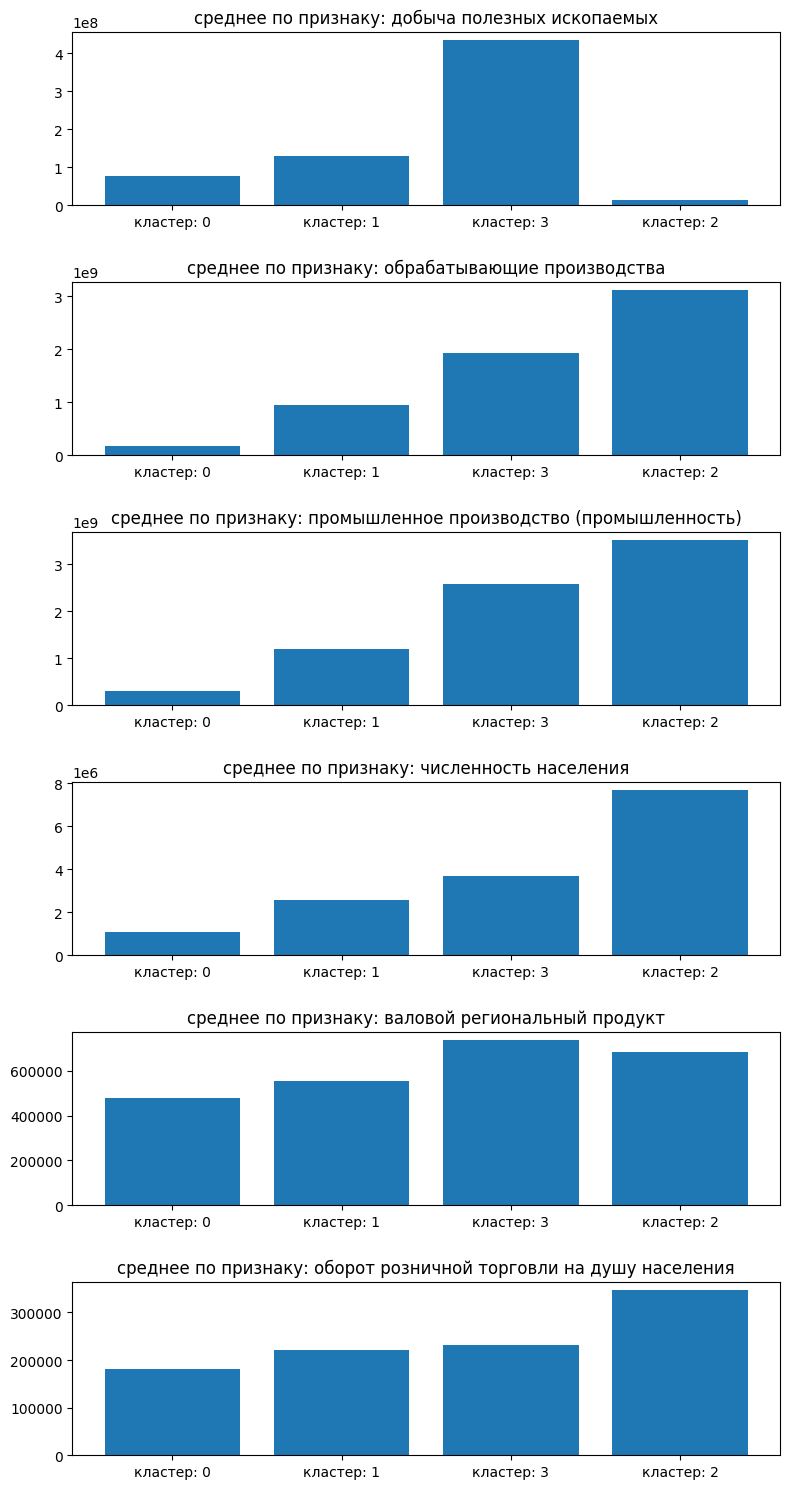

In [197]:
features = ['добыча полезных ископаемых', 'обрабатывающие производства', 
            'промышленное производство (промышленность)', 'численность населения', 
            'валовой региональный продукт', 'оборот розничной торговли на душу населения']
plot_avg_group(data, y, features, figsize=(8,15))

In [175]:
y.groupby('cluster', as_index=False)['region'].agg(['nunique', list])

,cluster,nunique,list
0,0,50,"[Алтайский край, Амурская область, Астраханска..."
1,1,15,"[Белгородская область, Иркутская область, Калу..."
2,2,1,[Московская область]
3,3,3,"[Красноярский край, Республика Татарстан, Свер..."


В кластер 0 попало 50 регионов из 69, однако среднее по кластеру самое низкое по всем признакам. Следовательно в 0 попали самые неблагополучные регионы, Московская область лидирует по, в 3ую группу попали всего 3 региона скорее всего из-за добычи полезных ископаемых.

In [230]:
# теперь нужно проверить разметку на классификации

x_train, x_test, y_train, y_test = train_test_split(X, y['cluster'], test_size=0.5, random_state=RANDOM_STATE)

In [233]:
from sklearn import linear_model
model = linear_model.LogisticRegression(multi_class='multinomial', max_iter=500, random_state=RANDOM_STATE)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [234]:
# сравним метрики
print(metrics.f1_score(y_test, y_pred, average='weighted'))
print(metrics.f1_score(y_train, model.predict(x_train), average='weighted'))

0.7679748822605965
0.8245614035087718


значения метрик не сильно разнятся для такого маленького набора данных, значит мдель кластеризации справилась со своей задачей